In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models,layers,callbacks

In [6]:
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

In [4]:
#function to trigger termination when adequate loss orr accuracy is achieved
class myCallback(callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        print("\nAccuracy is greater than 96% so terminating training!")
        self.model.stop_training=True

callbacks = myCallback()

In [7]:
#Loading Data

data = tf.keras.preprocessing.image_dataset_from_directory('train',shuffle=True,image_size=(256,256),batch_size=32)

Found 2100 files belonging to 6 classes.


In [8]:
test_data = tf.keras.preprocessing.image_dataset_from_directory('validation',shuffle=True,image_size=(256,256),batch_size=32)

Found 528 files belonging to 6 classes.


## Exploratory Data Analysis

In [9]:
disease = data.class_names
disease

['bacterial_leaf_blight',
 'brown_spot',
 'healthy',
 'leaf_blast',
 'leaf_scald',
 'narrow_brown_spot']

In [15]:
len(test_data)

17

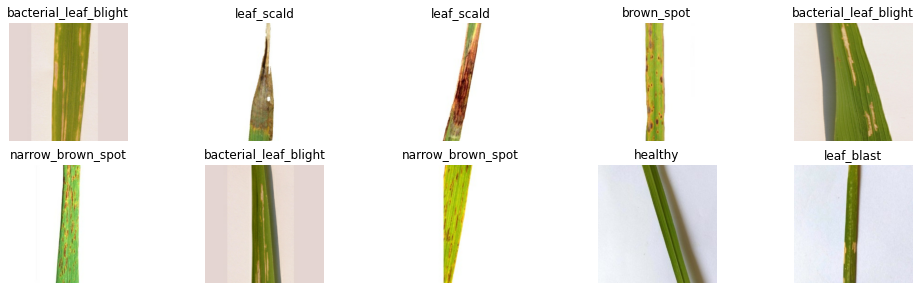

In [14]:
plt.figure(figsize=(17,10))
for img,lab in data.take(1):
    for i in range(10):
        ax= plt.subplot(4,5,i+1),
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(disease[lab[i]])
        plt.axis('off')

## Data preparation

In [16]:
## Train-test split

In [19]:
validation_data = test_data.take(8)

In [20]:
test= test_data.skip(8) # the 8 batches for valid are skipped and the rest used as test data

In [21]:
len(validation_data), len(test), len(data)

(8, 9, 66)

In [22]:
#`caching and prefetching pipeline

data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Building Pipelines

In [24]:
#rescaling
scale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Resizing(256,256),
                            tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)])

In [25]:
#Data Augmentation

augmentation= tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

## Model

In [28]:
model = models.Sequential([
    scale,augmentation,
    
    layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(6,activation='softmax')
])

model.build(input_shape=(32,256,256,3))

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [30]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [32]:
histroy=model.fit(data,epochs=50,batch_size=32,verbose=1,validation_data=validation_data)

Epoch 1/50
66/66 [==============================] - 90s 1s/step - loss: 1.5082 - accuracy: 0.3605 - val_loss: 1.3744 - val_accuracy: 0.4922
Epoch 2/50
66/66 [==============================] - 88s 1s/step - loss: 1.3758 - accuracy: 0.4305 - val_loss: 1.1927 - val_accuracy: 0.5977
Epoch 3/50
66/66 [==============================] - 89s 1s/step - loss: 1.1357 - accuracy: 0.5705 - val_loss: 0.9189 - val_accuracy: 0.6211
Epoch 4/50
66/66 [==============================] - 92s 1s/step - loss: 0.9619 - accuracy: 0.6381 - val_loss: 1.1582 - val_accuracy: 0.5781
Epoch 5/50
66/66 [==============================] - 93s 1s/step - loss: 0.8996 - accuracy: 0.6748 - val_loss: 0.7935 - val_accuracy: 0.6875
Epoch 6/50
66/66 [==============================] - 90s 1s/step - loss: 0.7267 - accuracy: 0.7286 - val_loss: 0.6537 - val_accuracy: 0.7695
Epoch 7/50
66/66 [==============================] - 90s 1s/step - loss: 0.7872 - accuracy: 0.6886 - val_loss: 0.7877 - val_accuracy: 0.6875
Epoch 8/50
66/66 [==

## Test Evaluation

In [33]:
score = model.evaluate(test)

9/9 [==============================] - 4s 370ms/step - loss: 0.4442 - accuracy: 0.8456


In [35]:
histroy.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
loss= histroy.history['loss']
val_loss = histroy.history['val_loss']
acc= histroy.history['accuracy']
val_acc=histroy.history['val_accuracy']

Text(0.5, 1.0, 'Training & Validation Accuracy')

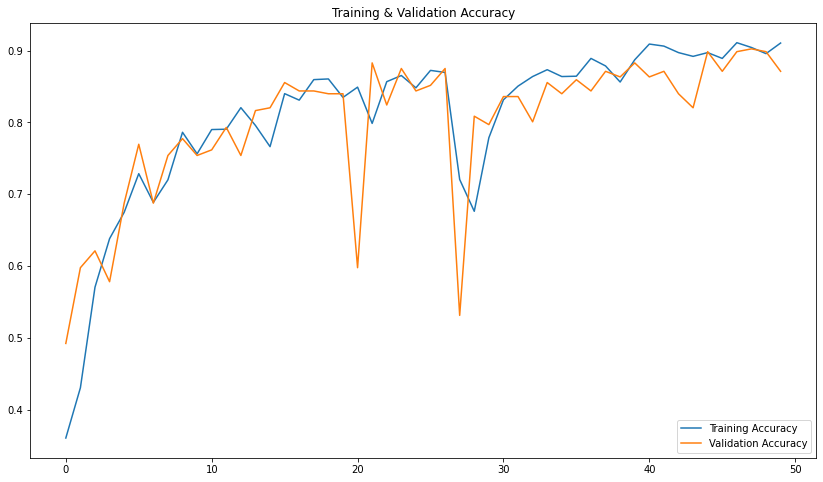

In [38]:
plt.figure(figsize=(31,8))
plt.subplot(1,2,1)
plt.plot(range(50),acc,label="Training Accuracy")
plt.plot(range(50),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training & Validation Accuracy")

Text(0.5, 1.0, 'Training & Validation Loss')

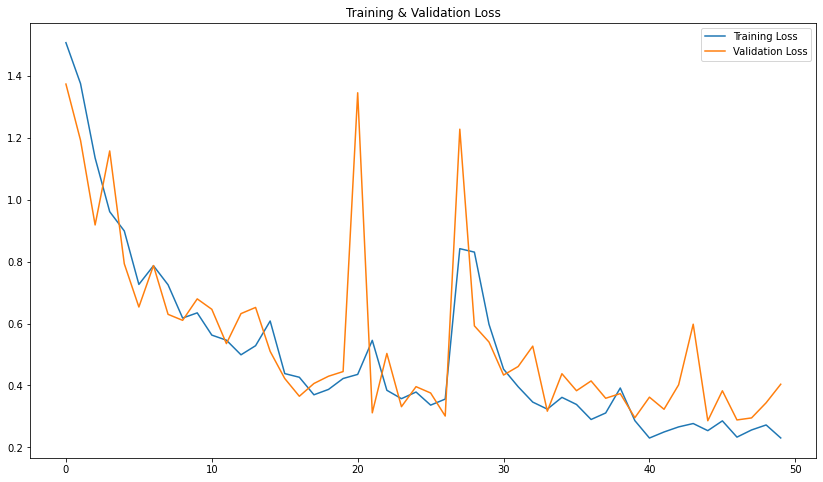

In [40]:
plt.figure(figsize=(31,8))
plt.subplot(1,2,1)
plt.plot(range(50),loss,label="Training Loss")
plt.plot(range(50),val_loss,label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training & Validation Loss")

## Testing 

In [41]:
first_batch = test.take(1)

In [42]:
first_batch

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

1/1 [==============================] - 1s 835ms/step

True : brown_spot
Predicted : brown_spot


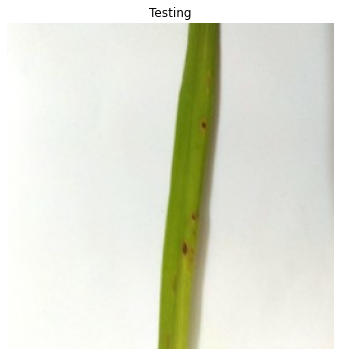

In [43]:
plt.figure(figsize=(6,6))
for img, clf in first_batch:
    random_img = img[0].numpy().astype("uint8")
    typ = clf[0].numpy()
    
    plt.imshow(random_img)
    plt.axis('off')
    plt.title("Testing")
    prediction = model.predict(img)
    
    print("\nTrue :",disease[typ])
    print("Predicted :",disease[np.argmax(prediction[0])])

In [44]:
def prediction(img):
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = tf.expand_dims(array,0)
    
    prediction = model.predict(array)
    
    clf = disease[np.argmax(prediction[0])]
    confidence = round(100* (np.max(prediction[0])),2)
    return clf,confidence

1/1 [==============================] - 0s 29ms/step


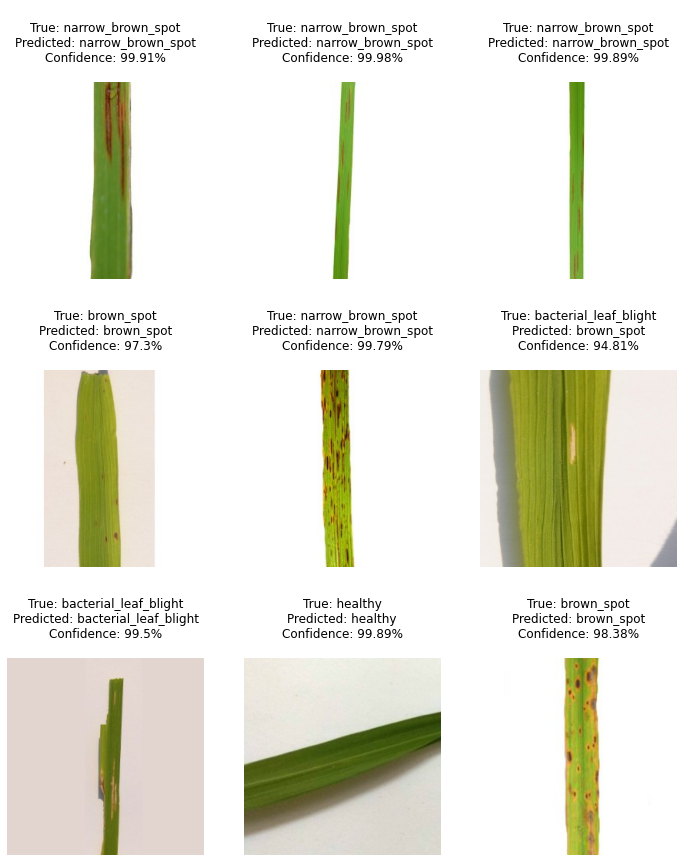

In [47]:
plt.figure(figsize=(12,15))
for img,lab in first_batch:
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        
        pred,conf = prediction(img[i].numpy())
        true = disease[lab[i]]
        plt.title(f"\nTrue: {true}\nPredicted: {pred}\nConfidence: {conf}%\n")
        plt.axis('off')

## Saving model

In [49]:
model.save(f"model")
print(f"Model created successfully")

Model created successfully
